In [2]:
%load_ext autoreload
%autoreload 3


import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Set
import abc
import torch
import dataclasses
import pandas as pd
import os
import copy
import time
import tqdm
from opt import opt_cache_simulation
import random


from cache import Cache
from eviction import LRU, DOM, MQ, RandomEvictor
from prefetch import Next, Markov, EnsamblePrefetcher
from prob_model import FFM
from markov_generator import RandomMarkovGenerator
from fieldfm import train_ffm, FieldAwareFactorizationMachine, FieldAwareFactorizationMachineModel


In [3]:
from pinatrace_dataset import read_trace as pin_read_trace

trace = pin_read_trace()

pcs = list(set(t[0] for t in trace))
addrs = list(set(t[2] for t in trace))

print(f"Number of pcs: {len(pcs)}")
print(f"Number of addrs: {len(addrs)}")

Number of pcs: 81
Number of addrs: 39


In [4]:
from rnn_pc import test_on_sequence
from mapping import Mapping

delta_mapping = Mapping(100, hash_mapping=False)
addr_mapping = Mapping(100, hash_mapping=False)
pc_mapping = Mapping(100, hash_mapping=False)


optimizer_config = dict(
    lr=1e-4, wd=1e-3
)

model_config = dict(
    emb_size=16, delta_emb_size=16, pc_emb_size=16, hidden_size=16, rnn_layers=1
)

train_config = dict(
    train_samples=128,
    train_interval=50,
    batch_size=8,
    cache_replacement=0,
    loss_delta_weight=0.0,
    loss_pc_weight=0.2,
    loss_ab_weight=1.0,
)

config = dict(
    addr_mapping=addr_mapping, pc_mapping=pc_mapping, delta_mapping=delta_mapping,
    cache_size=4, greedy=False, history_size=16,
    count_mistakes=True, classify_cutoff=0.0,

)


In [5]:


trace_shorted = trace[:50000]

def test(**extra_config):
    all_config = config | train_config | optimizer_config | model_config
    tconfig = copy.deepcopy(all_config)
    tconfig.update(extra_config)
    losses = []
    for i in range(3):
        torch.manual_seed(i)
        np.random.seed(i)
        random.seed(i)

        misses, misses_history, losses_, evict_counts, model = test_on_sequence(
            trace_shorted, **tconfig
        )
        losses.append(losses_[0])

    return losses

#losses_only_ab = test(loss_delta_weight=0.0, loss_pc_weight=0.0, rnn_layers=1)
losses_only_ab_pc = test(loss_delta_weight=0.0, loss_pc_weight=1, loss_ab_weight=0, rnn_layers=2, lr=1e-4)


Misses: 10050, Random misses: 9546, misses/random: 1.053, All Mistakes: 0.537, Mistakes 0: 0.650, Mistakes 0.5: 0.000, Mistakes 1: 0.537, Hits: 0.710, Loss p(a,b): 0.7125443518161774, Loss delta: 0.0, Loss pc: 4.091433048248291, Random loss: 0.6914623940692228: 100%|██████████| 34605/34605 [05:29<00:00, 104.88it/s]
Misses: 173, Random misses: 171, misses/random: 1.012, All Mistakes: 0.454, Mistakes 0: 0.450, Mistakes 0.5: 0.000, Mistakes 1: 0.454, Hits: 0.685, Loss p(a,b): 0.7393733613631305, Loss delta: 0.0, Loss pc: 4.601822909186868, Random loss: 0.699706091600306:   2%|▏         | 550/34605 [00:04<04:08, 137.32it/s] 


KeyboardInterrupt: 

In [27]:
def plot_mean_losses(losses: list[list[float]], title: str, window=20):
    losses = np.array(losses)
    mean = np.mean(losses, axis=0)
    std = np.std(losses, axis=0)
    mean = np.convolve(mean, np.ones(window) / window, mode='valid')
    std = np.convolve(std, np.ones(window) / window, mode='valid')
    plt.plot(mean, label=title)
    plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.3)


In [25]:
losses_only_ab_delta = test(loss_delta_weight=.4, loss_pc_weight=0.0, rnn_layers=1)

/Users/robertlaskowski/Desktop/studia/projects/prefetching/IDEAS_prefetchers/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Misses: 12307, Random misses: 9546, misses/random: 1.289, All Mistakes: 0.191, Mistakes 0: 0.000, Mistakes 0.5: 0.000, Mistakes 1: 0.191, Hits: 0.644, Loss p(a,b): 0.329452584771549, Loss delta: 4.063383747549618, Loss pc: 0.0, Random loss: 0.7063099882181954: 100%|██████████| 34605/34605 [09:05<00:00, 63.48it/s]   
/Users/robertlaskowski/Desktop/studia/projects/prefetching/IDEAS_prefetchers/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=

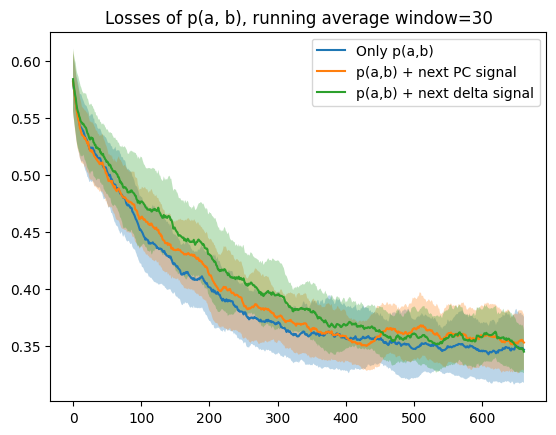

In [28]:
window = 30
plot_mean_losses(losses_only_ab, "Only p(a,b)", window=window)
plot_mean_losses(losses_only_ab_pc, "p(a,b) + next PC signal", window=window)
plot_mean_losses(losses_only_ab_delta, "p(a,b) + next delta signal", window=window)

plt.title(f"Losses of p(a, b), running average window={window}")
plt.legend()
plt.show()
